- this notebook was used to try different ways of defining accuracy
    - acc = 1-loss
    - acc = sum (scene == argmax(proba))

In [1]:
import sys
import itertools
import os
import numpy as np
import torch as tr
import pandas as pd

from CSWSEM import *
from matplotlib import pyplot as plt

%load_ext autoreload
%reload_ext autoreload
%autoreload 2

In [2]:
from sklearn.linear_model import LogisticRegression

def compute_exphat_proba(embed_mat,exphat):
  """
  embed_mat from task.embed_mat
  exphat (200,5,10) 
    contains gaussian vectors
    last dim is obsdim
  returns exphat_proba (200,5,11)
    last dim is num nodes
  """
  # fit classifier
  clf_class = LogisticRegression
  clf_kwargs = dict(C=10.0, multi_class='multinomial', solver='lbfgs')
  decoder = clf_class(**clf_kwargs)
  decoder.fit(embed_mat,
              np.arange(embed_mat.shape[0])
  )
  # compute proba
  exphat_proba = decoder.predict_proba(
                exphat.reshape(-1,10) # 10 is obs_dim
                ).reshape(200,5,11) # 11 is num_scenes
  return exphat_proba


In [3]:
layer2scene_dict = {
  0:[1,2],1:[3,4],
  2:[5,6],3:[7,8],
  4:[9,10]
}

def compute_afc_proba(exphat_proba):
  """ normalizes proba by layer
  """
  afc_proba = -np.ones([200,len(layer2scene_dict),2],dtype=float)
  for idx,(layer_idx,scenes) in enumerate(layer2scene_dict.items()):
    # get relevant probas
    layer_proba_ = exphat_proba[:,layer_idx,scenes]
    layer_proba_normalized = layer_proba_ / layer_proba_.sum(1,keepdims=1)
    # normalize
    afc_proba[:,idx] = layer_proba_normalized
  return afc_proba

def argmax_action_selection(afc_proba):
  choice = -np.ones([200,5],dtype=int)
  for idx,(layer_idx,scenes) in enumerate(layer2scene_dict.items()):
    choice[:,idx] = np.take(
        np.repeat([scenes],200,axis=0),
        afc_proba[:,idx,:].argmax(1)
    )
  return choice

def score_choice(embed_mat,exphat):
  """ 
  calculates a score based on argmax response
  """
  # translate network output into distribution over scenes
  exphat_proba = compute_exphat_proba(embed_mat,exphat)
  # normalize distribution over all scenes to two possible future scenes
  afc_proba = compute_afc_proba(exphat_proba)
  # using afc_proba, select action (i.e. predicted scene)
  choices = argmax_action_selection(afc_proba)
  # evaluate network response against environment
  score = np.sum(task.exp_int[:,(3,4)] == choices[:,(2,3)],1) 
  return score

def score_proba_correct(embed_mat,exphat):
  """ 
  calculates a score based on proba assigned to correct 
  """
  # translate network output into distribution over scenes
  exphat_proba = compute_exphat_proba(embed_mat,exphat)
  # normalize distribution over all scenes to two possible future scenes
  afc_proba = compute_afc_proba(exphat_proba)
  return score

In [6]:
## input params
learn_rate = 0.05
alfa = 0.0001
lmda = 100000
stsize = 35

In [13]:
# exphat = np.array([tdata['event_hat'] for tdata in sem_data])

(200, 5, 10)

In [7]:
condL = ['blocked','interleaved']

exp_kwargs={
    'n_train':160,
    'n_test':40
}

sem_kwargs={
    'nosplit':False,
    'stsize':stsize,
    'lmda':lmda,
    'alfa':alfa,
    'learn_rate':learn_rate,
}
num_seeds = 10
dataL = []
exphat = np.ones(num_seeds,len(condL),200,5,10) # (trials,tsteps,obsdim)
for seed in np.arange(num_seeds):
  for cidx,cond in enumerate(condL):
    print(seed,cond)
    np.random.seed(seed)
    tr.manual_seed(seed)
    sem_kwargs['seed'] = seed
    # setup
    exp_kwargs['condition'] = cond
    task = CSWTask(seed)
    sem = SEM(**sem_kwargs)
    exp,curr = task.generate_experiment(**exp_kwargs)
    # run
    sem_data = sem.forward_exp(exp,curr)
    ### eval
    exphat[seed,cdix] = np.array([tdata['event_hat'] for tdata in sem_data])
    score[seed,cidx] = score_choice(task.embed_mat,exphat)
    # record data
    sem.data.record_exp('condition',exp_kwargs['condition'])
    dataL.append(pd.DataFrame(sem_data))
    


0 blocked
0 interleaved
1 blocked
1 interleaved
2 blocked
2 interleaved
3 blocked
3 interleaved
4 blocked
4 interleaved
5 blocked
5 interleaved
6 blocked
6 interleaved
7 blocked
7 interleaved
8 blocked
8 interleaved
9 blocked
9 interleaved


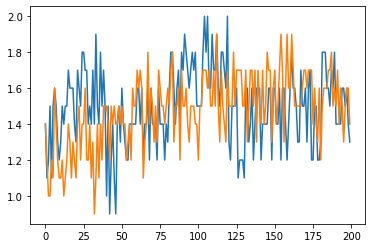

In [8]:
acc = score.mean(0)
plt.plot(acc[0])
plt.plot(acc[1])

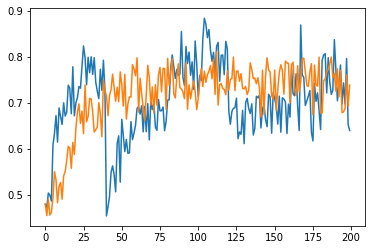

In [9]:
""" 
plt 1-loss
"""

data = pd.concat(dataL)
# def format_dataL(dataL):
df = pd.concat(dataL)
df = df.astype({'loss':float})
df.loc[:,'acc1'] = 1-df.loss
#   return df
# format_dataL(dataL)


df.groupby(['condition','seed','trial']).mean()
for cond in ['blocked','interleaved']:
  cond_df = df[df.loc[:,'condition'] == cond]
  M = cond_df.groupby('trial').mean()
  plt.plot(M.loc[:,'acc1'])